                            Ghouila Mohamed - Chambon Thomas - Medbouhi Adam - Cornuejouls Damien

# Mini-projet n° 4 – **RNN, LSTM et GRU vs MLP et CNN**

In [1]:
import torch
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torchmetrics.classification import BinaryF1Score
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import time
import hashlib
from transformers import DistilBertTokenizerFast, DistilBertModel
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import random

Cette section importe tous les packages et librairies nécessaires à l'exécution des cellules qui suivent.

*Note : Si vous utilisez `Docker`, une image de base avec un fichier `requirements.txt` est fournie.*

Ici, on récupère le jeu de données [IMDB](https://ai.stanford.edu/~amaas/data/sentiment/). La partie labélisée va nous permettre de faire une étude de sentiments (positif ou négatif).

In [2]:
# Takes a long time...
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip > /dev/null 2>&1

--2024-12-19 13:08:15--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-19 13:08:15--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M   385KB/s    in 39m 4s  

2024-12-19 13:47:20 (359 KB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



Les quelques hyper-paramètres utiles pour la suite et qu'on a cherché à optimiser. On détaillera ce point un peu plus tard.

In [2]:
# Global variables
BATCH_SIZE = 8
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 1
DROPOUT = 0.2
NUM_LAYERS = 2
NUM_EPOCHS = 5
LEARNING_RATE = 1e-3
THRESHOLD = 0.5
GLOVE_PATH = "glove.6B.100d.txt"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


## **Construction du vocabulaire basique**

L'intérêt de cette fonction est d'itérer sur toutes les données du jeu de `train` et de les *tokenizer* pour un `tokenizer` donné.

In [3]:
# Build vocab
def yield_tokens(data_iter, tokenizer, model_name='basic'):
    if model_name == 'basic':
        for _, text in data_iter:
            yield tokenizer(text)

train_iter = IMDB(split='train')

Le `tokenizer` choisi est assez basique. Il réalise quelques transformations sur nos textes anglais.
*   Conversion en minuscules
*   Suppression des ponctuations
*   Découpage par espaces
*   Conservation des mots composés

Notre vocabulaire est ensuite construit et correspond à l'ensemble des `tokens` vus lors des itérations sur le jeu de `train`. On constate que nos textes d'entrainement contiennent ainsi plus de 100 000 `tokens` différents.

*Note : De façon générale, les `tokens` ne correspondent ni à des mots ni à des caractères.*

In [4]:
# Load tokenizer
basic_tokenizer = get_tokenizer("basic_english")
basic_vocab = build_vocab_from_iterator(yield_tokens(train_iter, basic_tokenizer, model_name='basic'), specials=['<unk>'])
basic_vocab.set_default_index(basic_vocab['<unk>'])  # Default index for unknown words
BASIC_VOCAB_SIZE = len(basic_vocab)
BASIC_PAD_IDX = basic_vocab['<unk>'] # 0
print(f"Basic vocab length: {BASIC_VOCAB_SIZE}")

Basic vocab length: 100683


## **Contrôle des données**

Pour éviter tout comportement problématique et éviter de biaiser nos modèles, on a décidé de faire une pré-analyse sur nos données. Concrétement, on vérifie que nos données sont **uniques** et que nos datasets sont **disjoints**.

In [5]:
# Function for calculating a unique hash for each data item
def hash_data(data):
    _, text = data
    return hashlib.md5(text.encode('utf-8')).hexdigest()

# Deletes duplicates in the dataset
def remove_duplicates(data):
    seen = set()
    unique_data = []
    for item in data:
        data_hash = hash_data(item)
        if data_hash not in seen:
            seen.add(data_hash)
            unique_data.append(item)
    return unique_data

def verify_no_overlap(train_datas, val_datas, test_datas, hash_fn):
    # Hashes calculations
    train_hashes = set(hash_fn(data) for data in train_datas)
    val_hashes = set(hash_fn(data) for data in val_datas)
    test_hashes = set(hash_fn(data) for data in test_datas)

    assert train_hashes.isdisjoint(val_hashes), "Overlap between train and validation"
    assert train_hashes.isdisjoint(test_hashes), "Overlap between train and test"
    assert val_hashes.isdisjoint(test_hashes), "Overlap between validation and test"

    print("The data sets are well disjointed.")

In [6]:
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')
all_data = list(train_iter) + list(test_iter)
all_data = remove_duplicates(all_data)
all_hashes = [hash_data(data) for data in all_data]

# Check for duplicates
if len(all_hashes) != len(set(all_hashes)):
    print("Caution: Duplicate data exists!")
else:
    print("All data is unique.")

All data is unique.


In [7]:
TRAIN_SIZE = int(0.8 * len(all_data))
VAL_SIZE = int(0.1 * len(all_data))
TEST_SIZE = len(all_data) - TRAIN_SIZE - VAL_SIZE

train_datas, val_datas, test_datas = random_split(all_data, [TRAIN_SIZE, VAL_SIZE, TEST_SIZE])
verify_no_overlap(train_datas, val_datas, test_datas, hash_fn=hash_data) # Useless if we called 'remove_duplicates' previously

The data sets are well disjointed.


## **Analyse exploratoire**

### Répartition des données de `train` et de `test`

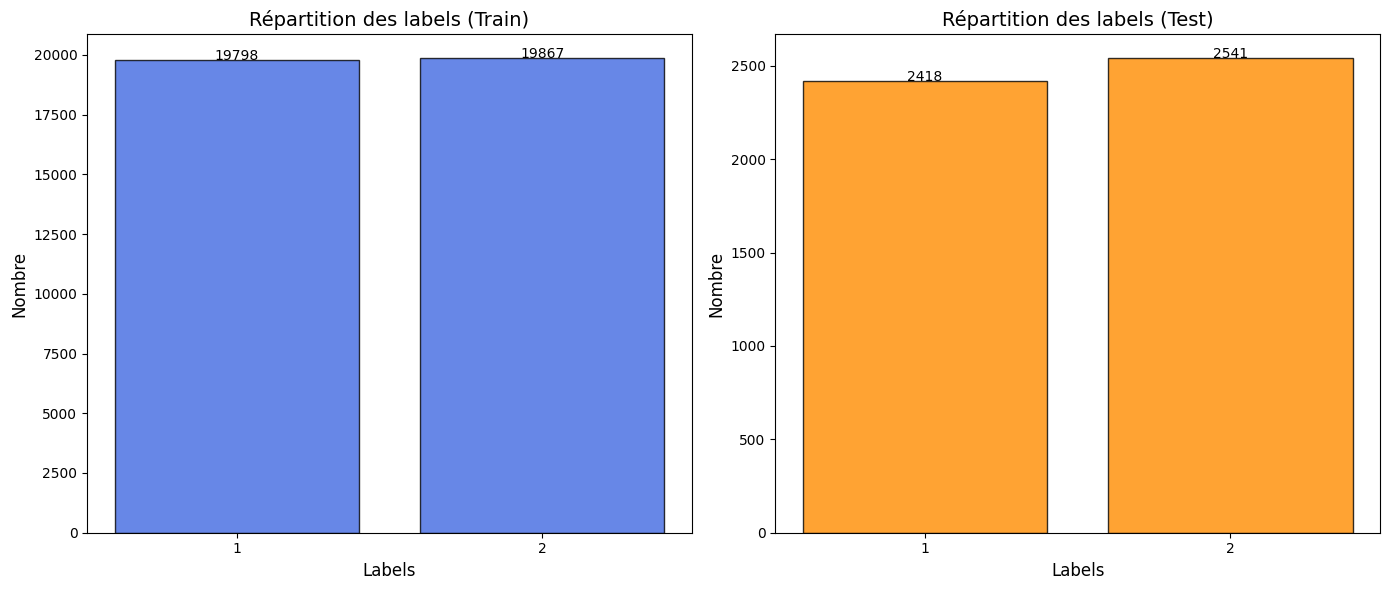

In [8]:
# Distribution des labels
train_labels = [label for label, _ in train_datas]
test_labels = [label for label, _ in test_datas]

train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Création des sous-plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Répartition des labels (train)
axes[0].bar(train_label_counts.keys(), train_label_counts.values(), color='royalblue', alpha=0.8, edgecolor='black')
axes[0].set_title('Répartition des labels (Train)', fontsize=14)
axes[0].set_xlabel('Labels', fontsize=12)
axes[0].set_ylabel('Nombre', fontsize=12)
axes[0].set_xticks(list(train_label_counts.keys()))
axes[0].tick_params(axis='both', which='major', labelsize=10)
for i, v in enumerate(train_label_counts.values()):
    axes[0].text(list(train_label_counts.keys())[i], v + 0.5, str(v), ha='center', fontsize=10)

# Répartition des labels (test)
axes[1].bar(test_label_counts.keys(), test_label_counts.values(), color='darkorange', alpha=0.8, edgecolor='black')
axes[1].set_title('Répartition des labels (Test)', fontsize=14)
axes[1].set_xlabel('Labels', fontsize=12)
axes[1].set_ylabel('Nombre', fontsize=12)
axes[1].set_xticks(list(test_label_counts.keys()))
axes[1].tick_params(axis='both', which='major', labelsize=10)
for i, v in enumerate(test_label_counts.values()):
    axes[1].text(list(test_label_counts.keys())[i], v + 0.5, str(v), ha='center', fontsize=10)

# Ajustements finaux
plt.tight_layout()
plt.show()

Nos jeux de données possèdent donc (presque) autant de textes avec des sentiments positifs, que négatifs.

*Note : Ici le 2 correspond aux textes aux sentiments positifs et 1 aux négatifs. On ramène plus tard lors de la création des `DataLoaders` les valeurs entre 1 et 0.*

### Longueur des textes

Il est pertinent de regarder la taille des textes pour choisir plus tard un modèle. On sait que si l'information associée aux sentiments est contenue par les mots en début de texte, et que nos textes sont longs, il vaut mieux privilégier des LSTM/GRU plutôt que des RNN. En effet, les RNN sont soumis aux problèmes de *vanishing gradient* qui conduit à une perte d'informations pour des instants lointains.

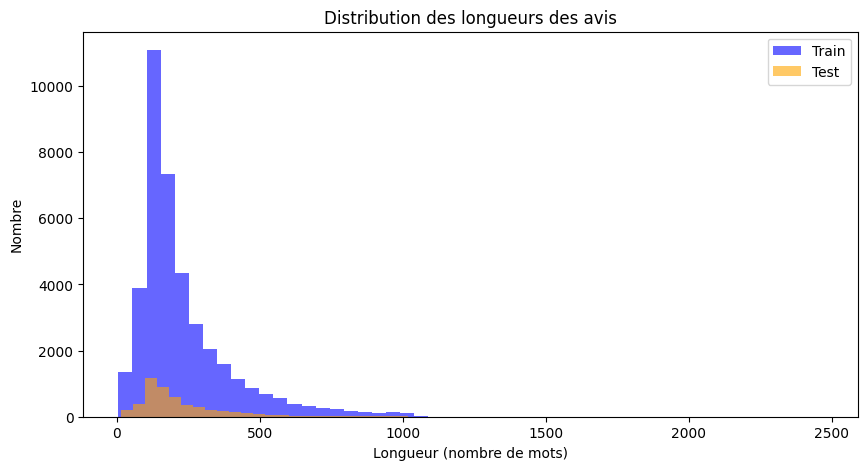

In [9]:
# Fonction pour calculer la longueur des avis
def review_lengths(data):
    return [len(review.split()) for _, review in data]

train_lengths = review_lengths(train_datas)
test_lengths = review_lengths(test_datas)

plt.figure(figsize=(10, 5))
plt.hist(train_lengths, bins=50, alpha=0.6, label='Train', color='blue')
plt.hist(test_lengths, bins=50, alpha=0.6, label='Test', color='orange')
plt.title('Distribution des longueurs des avis')
plt.xlabel('Longueur (nombre de mots)')
plt.ylabel('Nombre')
plt.legend()
plt.show()

Sur la figure, il faut s'intéresser à la plage de valeurs en abscisse et non au nombre d'occurrences. On constate alors que les jeux de `train` et de `test` ont des textes de longueurs comparables. Ceci est une bonne nouvelle pour l'évaluation de la performance de nos modèles.

### Longueur des textes associés aux sentiments

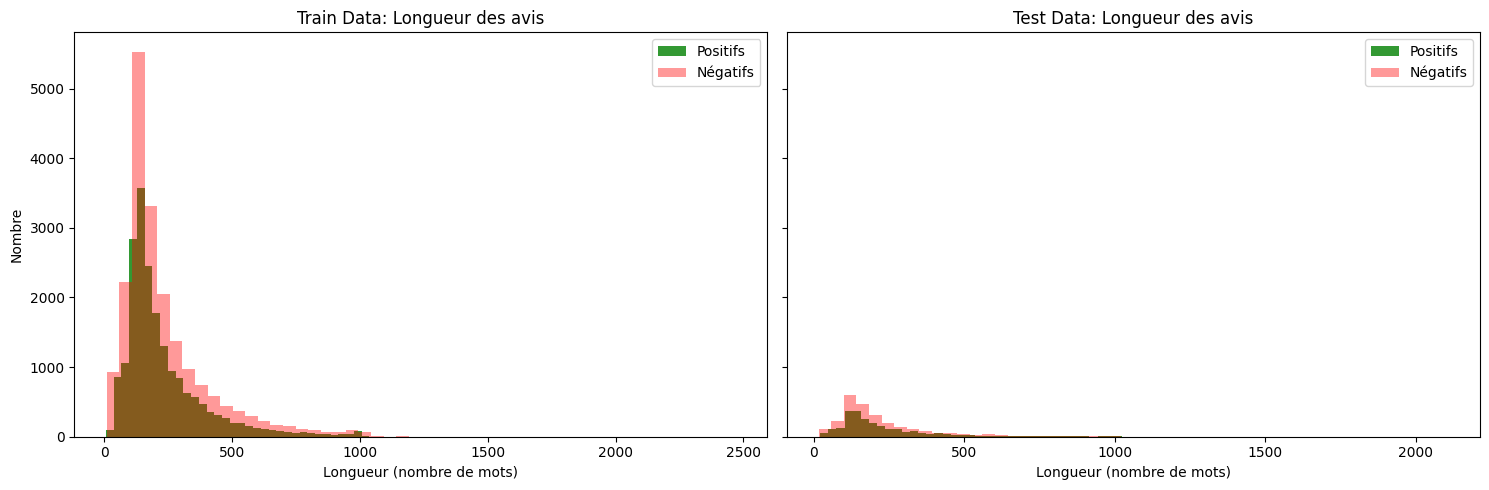

In [10]:
# Calcul des longueurs des avis positifs et négatifs dans les données d'entraînement
pos_lengths_train = [len(review.split()) for label, review in train_datas if label == 1]
neg_lengths_train = [len(review.split()) for label, review in train_datas if label == 2]

# Calcul des longueurs des avis positifs et négatifs dans les données de test
pos_lengths_test = [len(review.split()) for label, review in test_datas if label == 1]
neg_lengths_test = [len(review.split()) for label, review in test_datas if label == 2]

# Création des graphes côte à côte
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Graphe des données d'entraînement
axes[0].hist(pos_lengths_train, bins=50, alpha=0.8, label='Positifs', color='green')
axes[0].hist(neg_lengths_train, bins=50, alpha=0.4, label='Négatifs', color='red')
axes[0].set_title('Train Data: Longueur des avis')
axes[0].set_xlabel('Longueur (nombre de mots)')
axes[0].set_ylabel('Nombre')
axes[0].legend()

# Graphe des données de test
axes[1].hist(pos_lengths_test, bins=50, alpha=0.8, label='Positifs', color='green')
axes[1].hist(neg_lengths_test, bins=50, alpha=0.4, label='Négatifs', color='red')
axes[1].set_title('Test Data: Longueur des avis')
axes[1].set_xlabel('Longueur (nombre de mots)')
axes[1].legend()

plt.tight_layout()
plt.show()

Une fois encore, on constate que les avis associés aux sentiments positifs sont de longueurs environ équivalentes à celles des avis aux sentiments négatifs. On note tout de même que les avis négatifs sont globalement un peu plus courts que ceux positifs (en sachant qu'il y a environ autant d'avis positifs que négatifs). 

Ces différentes analyses nous autorisent à travailler avec des `loss`non pondérées selon la classe (à priori pas de`FocalLoss`).

## **Création des `DataLoaders`**

### Basic

Cette fonction permet de préparer nos données avant d'être utilisées pour construire nos `DataLoaders`. Elle recentre nos labels entre 0 et 1 et fournit pour chaque texte une liste d'indices. Ces indices correspondent à ceux des `tokens` du texte en question dans le vocabulaire précédemment construit.

In [11]:
def basic_collate_batch(batch):
    text_list, label_list = [], []
    for label, text in batch:
        text_list.append(torch.tensor(basic_vocab(basic_tokenizer(text)), dtype=torch.int32))
        label_list.append(label-1)
    text_tensor = pad_sequence(text_list, batch_first=True, padding_value=BASIC_PAD_IDX)
    label_tensor = torch.tensor(label_list, dtype=torch.float32)
    return text_tensor, label_tensor

In [12]:
basic_train_loader = DataLoader(train_datas, batch_size=BATCH_SIZE, shuffle=True, collate_fn=basic_collate_batch, drop_last=True)
basic_val_loader = DataLoader(val_datas, batch_size=BATCH_SIZE, shuffle=True, collate_fn=basic_collate_batch, drop_last=False)
basic_test_loader = DataLoader(test_datas, batch_size=1, shuffle=False, collate_fn=basic_collate_batch, drop_last=False)

# Print loaders' sizes
print(f"Size train loader : {len(basic_train_loader.dataset)}")
print(f"Size validation loader : {len(basic_val_loader.dataset)}")
print(f"Size test loader : {len(basic_test_loader.dataset)}")

Size train loader : 39665
Size validation loader : 4958
Size test loader : 4959


### Bert

Le principe pour `Bert` est similaire à celui des cellules du dessus. Cependant, comme on utilise un `tokenizer` différent, et un vocabulaire différent, on est contraints de construire de nouveaux `DataLoaders`.

In [13]:
bert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
BERT_PAD_IDX = bert_tokenizer.pad_token_id # 0

def bert_collate_batch(batch):
    text_list, label_list = [], []
    for label, text in batch:
        item = bert_tokenizer(text, truncation=True, return_tensors="pt")  # possible ajout : padding=True
        text_list.append(item["input_ids"].squeeze(0))
        label_list.append(label-1)
    padded_text_ids = pad_sequence(text_list, batch_first=True, padding_value=BERT_PAD_IDX)
    label_list = torch.tensor(label_list, dtype=torch.float32)
    return padded_text_ids, label_list

# Pour avoir le mask d'attention :
# item["attention_mask"]

In [14]:
bert_train_loader = DataLoader(train_datas, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bert_collate_batch, drop_last=True)
bert_val_loader = DataLoader(val_datas, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bert_collate_batch, drop_last=False)
bert_test_loader = DataLoader(test_datas, batch_size=1, shuffle=False, collate_fn=bert_collate_batch, drop_last=False)

# Print loaders' sizes
print(f"Size train loader : {len(bert_train_loader.dataset)}")
print(f"Size validation loader : {len(bert_val_loader.dataset)}")
print(f"Size test loader : {len(bert_test_loader.dataset)}")

Size train loader : 39665
Size validation loader : 4958
Size test loader : 4959


## **Chargement d'embeddings pré-entrainés**

A chacun de nos `tokens`, on va faire correspondre un vecteur d'*embeddings*. Il est possible pour le modèle d'apprendre ces vecteurs, ou bien encore d'en récupérer des existants. C'est ce que réalisent les deux cellules qui suivent. On récupère d'une part les *Glove embeddings* et d'autre part les *Bert embeddings*. Ces derniers sont à utiliser avec les `DataLoaders` correspondants.

### Glove

In [15]:
def load_glove_embeddings(vocab, path=GLOVE_PATH, embedding_dim=EMBEDDING_DIM):
    # Load GloVe embeddings into a dictionary
    glove_embeddings = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:embedding_dim+1]], dtype=torch.float32) # works if we choose an emb dim < 100
            glove_embeddings[word] = vector

    # Create a weights matrix for words in vocab
    weights_matrix = torch.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.get_stoi().items():
        if word in glove_embeddings:
            weights_matrix[idx] = glove_embeddings[word]
        else:
            weights_matrix[idx] = torch.zeros(embedding_dim)
    return weights_matrix

GLOVE_EMBS = load_glove_embeddings(basic_vocab)
print(GLOVE_EMBS.shape)

torch.Size([100683, 100])


### Bert

In [16]:
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")
BERT_EMBS = bert_model.embeddings.word_embeddings.weight
BERT_EMB_SIZE = 768
print(BERT_EMBS.shape)

torch.Size([30522, 768])


## **Définition de nos modèles**

Dans cette section, on va définir tous les modèles que nous allons comparer. La première chose notable et commune à nos modèles est la couche d'*embeddings*. Comme dit plus haut, celle-ci peut-être à apprendre, ou déjà pré-entrainée. Dans les deux cas, on affichera le nombre de paramètres à optimiser. On verra que ce nombre est bien plus faible lorsque nous prenons des *embeddings* déjà entrainés. Aussi, notre sortie contient systématiquement un seul neurone sur lequel on applique une fonction type `nn.Sigmoid`. On procède ensuite par seuillage pour classer le sentiment du texte en question.

### MLP

Ce premier modèle est simple. Il contient uniquement des couches *Fully connected* ou *dense*. Le `Dropout` prévient le sur-ajustement du modèle et la non-linéarité est apportée par la fonction `nn.ReLU`.

In [17]:
class MLPClassifier(nn.Module):
    def __init__(self, vocab_size=BASIC_VOCAB_SIZE, embed_size=EMBEDDING_DIM, hidden_size=HIDDEN_DIM, output_size=OUTPUT_DIM, dropout=DROPOUT, pretrained_embs=None, pretrained=False):
        super(MLPClassifier, self).__init__()

        # Embedding layer
        if pretrained:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embs, freeze=True)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)

        self.fc1 = nn.Linear(embed_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)

        self.dropout = nn.Dropout(dropout)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_size)
        x = embedded.mean(dim=1)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return self.sigmoid(x)

### CNN 1D

On est habitués à travailler avec des couches de convolution pour des images type `nn.Conv2d`. Or ici, les données sont textuelles, il faut donc employer des convolutions 1D comme `nn.Conv1d`. Ce modèle exploite ces convolutions pour extraire des motifs locaux dans les séquences, ce qui le rend plus sophistiqué pour des données textuelles riches en structure. Le fonction de ces couches est décrit à travers le schéma suivant : 

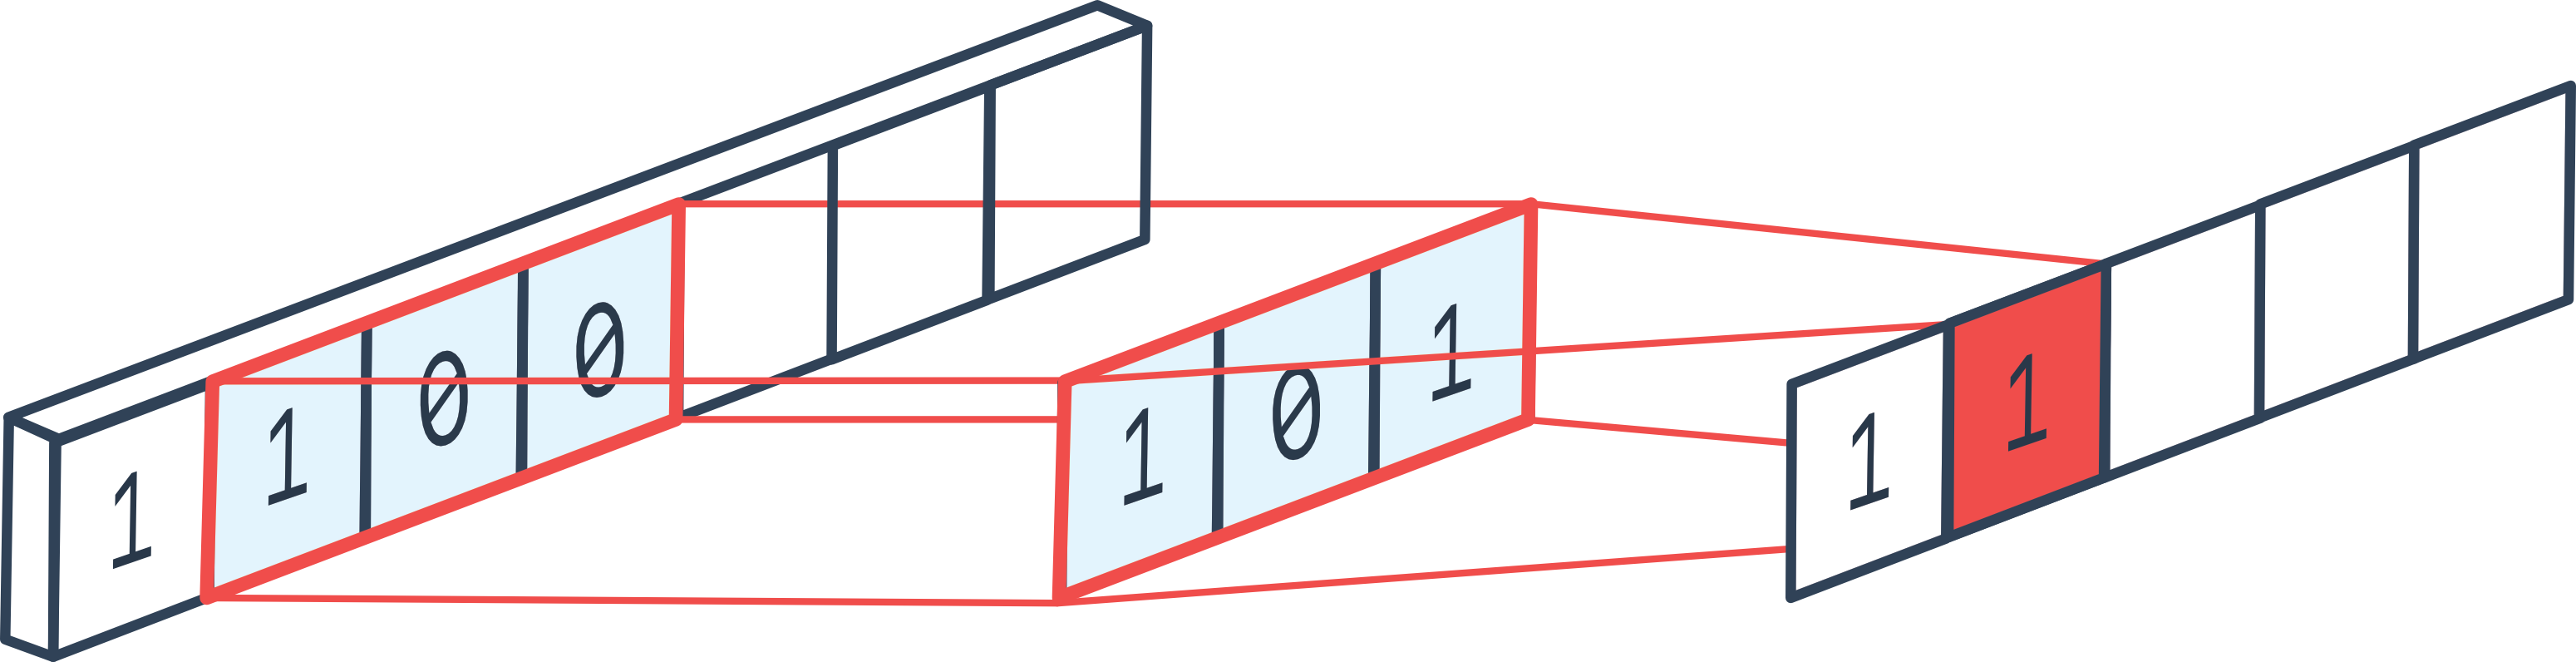

*Crédits : https://stackoverflow.com/questions/65006011/size-of-output-of-a-conv1d-layer-in-keras*

In [18]:
class CNN1DClassifier(nn.Module):
    def __init__(self, vocab_size=BASIC_VOCAB_SIZE, embed_size=EMBEDDING_DIM, pretrained_embs=None, pretrained=False):
        super(CNN1DClassifier, self).__init__()

        if pretrained:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embs, freeze=True)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)

        self.conv1 = nn.Conv1d(in_channels=embed_size, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(DROPOUT)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embed_size)
        embedded = embedded.permute(0, 2, 1)  # Convert to (batch_size, embed_size, seq_len) for Conv1D

        x = self.relu(self.conv1(embedded))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))

        # Global max pooling
        x = F.adaptive_max_pool1d(x, 1).squeeze(2)  # Shape: (batch_size, out_channels)

        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return self.sigmoid(x)

### RNN

Les trois prochains réseaux sont emploient des couches **récurrentes**. Leur architecture est semblable. On utilise soit des couches type `nn.RNN`, soit `nn.LSTM` ou encore `nn.GRU`. Pour faire l'analogie avec ce qui a été vu en cours, il s'agit d'un réseau *Many-to-One*. Il peut être vu comme sur l'image qui suit :

<div style="text-align: center;">
    <img src="https://goodboychan.github.io/images/copied_from_nb/image/many-to-one.png" style="width:400px; height:400px;">
</div>

*Crédits : https://goodboychan.github.io/python/deep_learning/tensorflow-keras/2020/12/06/01-RNN-Many-to-one.html*

In [19]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size = BASIC_VOCAB_SIZE, embed_size = EMBEDDING_DIM, hidden_size = HIDDEN_DIM, output_size = OUTPUT_DIM, num_layers=NUM_LAYERS, dropout=DROPOUT, pretrained_embs=None,
                  pretrained=False):
        super(RNNClassifier, self).__init__()

        if pretrained:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embs, freeze=True)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)

        self.add_fc = False
        if pretrained and pretrained_embs.size(1) != embed_size:
            self.fc1 = nn.Linear(pretrained_embs.size(1), embed_size)
            self.add_fc = True

        self.rnn = nn.RNN(embed_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True, nonlinearity='tanh')
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        if self.add_fc:
            embedded = self.fc1(embedded)

        rnn_out, hidden = self.rnn(embedded)
        last_hidden_state = hidden[-1]
        output = self.fc2(last_hidden_state)
        return self.sigmoid(output)


### LSTM

On utilise dans ce modèle des portes `nn.LSTM`. 

<div style="text-align: center;">
    <img src="https://db0dce98.rocketcdn.me/wp-content/uploads/2023/10/image1.png" style="width:500px; height:400px;">
</div>

*Crédits : https://datascientest.com/long-short-term-memory-tout-savoir*

In [20]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size=BASIC_VOCAB_SIZE, embed_size=EMBEDDING_DIM, hidden_size=HIDDEN_DIM,
                 output_size=OUTPUT_DIM, dropout=DROPOUT, num_layers=NUM_LAYERS, pretrained_embs=GLOVE_EMBS, pretrained=False):
        super(LSTMClassifier, self).__init__()
        if pretrained:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embs, freeze=True) # To ensure weights are not trained
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)

        self.add_fc = False
        if pretrained and pretrained_embs.size(1) != embed_size:
            self.fc1 = nn.Linear(pretrained_embs.size(1), embed_size)
            self.add_fc = True

        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        if self.add_fc:
            embedded = self.fc1(embedded)
        lstm_out, (hidden, _) = self.lstm(embedded)
        output = self.fc2(hidden[-1])
        return self.sigmoid(output)

### GRU

Enfin, on va tester les performances des portes `nn.GRU`. 

<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Gated_Recurrent_Unit%2C_base_type.svg/780px-Gated_Recurrent_Unit%2C_base_type.svg.png?20180416083255" style="width:600px; height:400px;">
</div>

*Crédits : https://commons.wikimedia.org/wiki/File:Gated_Recurrent_Unit,_base_type.svg*

In [21]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size=BASIC_VOCAB_SIZE, embed_size=EMBEDDING_DIM, hidden_size=HIDDEN_DIM,
                 output_size=OUTPUT_DIM, dropout=DROPOUT, num_layers=NUM_LAYERS, pretrained_embs=GLOVE_EMBS, pretrained=False):
        super(GRUClassifier, self).__init__()
        if pretrained:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embs, freeze=True) # To ensure weights are not trained
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)

        self.add_fc = False
        if pretrained and pretrained_embs.size(1) != embed_size:
            self.fc1 = nn.Linear(pretrained_embs.size(1), embed_size)
            self.add_fc = True

        self.gru = nn.GRU(embed_size, hidden_size, num_layers=num_layers,
                          dropout=dropout, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        if self.add_fc:
            embedded = self.fc1(embedded)
        gru_out, _ = self.gru(embedded)
        last_hidden_state = gru_out[:, -1, :]
        output = self.fc2(last_hidden_state)
        return self.sigmoid(output)

## **Fonctions de `test` et de `train`**

Les fonctions `train` et `test` sont utilisées systématiquement pour entrainer et evaluer la qualité de nos modèles. On a décidé d'inclure une option dans la fonction d'entrainement afin de récupérer la valeur des gradients et de les afficher si voulu. Ceci nous a semblé pertinent, notamment pour comparer les modèles *RNN*, *LSTM* et *GRU*, et justifier leur performance. La fonction `set_seed` permet la reproductibilité des expériences. Si on se retrouve dans le cas de minimaux locaux lors des entrainements, on peut changer sa valeur pour initialiser différents les poids des modèles.

In [22]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Train function
def train_epoch(model, data_loader, criterion, optimizer, threshold=THRESHOLD, plot_grad=False):
    model.train()
    total_loss, total_acc = 0, 0
    size_loader = 0
    f1_metric = BinaryF1Score().to(DEVICE)

    # Initialize a list to store gradient magnitudes if plotting is enabled
    gradient_magnitudes = [] if plot_grad else None

    for text, labels in tqdm(data_loader):
        text, labels = text.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        output = model(text).squeeze(dim=1)  # could use .squeeze() if drop_last=True
        loss = criterion(output, labels)
        loss.backward()

        # If plot_grad is True, calculate gradient magnitudes
        if plot_grad:
            total_grad = 0
            count = 0
            for name, param in model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    total_grad += param.grad.norm().item()
                    count += 1
            gradient_magnitudes.append(total_grad / count if count > 0 else 0)

        optimizer.step()

        # Metrics part
        total_loss += loss.item()
        preds = (output >= threshold)
        total_acc += (preds == labels).sum().item()
        f1_metric.update(preds, labels)
        size_loader += labels.size(0)

    f1 = f1_metric.compute()
    f1_metric.reset()

    # Plot the gradients if requested
    if plot_grad:
        plt.plot(range(len(gradient_magnitudes)), gradient_magnitudes)
        plt.xlabel("Batch")
        plt.ylabel("Average Gradient Magnitude")
        plt.title("Gradient Magnitudes per Batch")
        plt.show()

    return total_loss / size_loader, total_acc / size_loader, f1
    
# Test function
def evaluate(model, data_loader, criterion, threshold=THRESHOLD):
    model.eval()
    total_loss, total_acc = 0, 0
    size_loader = 0
    f1_metric = BinaryF1Score().to(DEVICE)
    with torch.no_grad():
        for text, labels in tqdm(data_loader):
            text, labels = text.to(DEVICE), labels.to(DEVICE)
            output = model(text).squeeze(dim=1)
            loss = criterion(output, labels)

            # Metrics part
            total_loss += loss.item()
            preds = (output >= threshold)
            total_acc += (preds == labels).sum().item()
            f1_metric.update(preds, labels)
            size_loader += labels.size(0)

    f1 = f1_metric.compute()
    f1_metric.reset()
    return total_loss / size_loader, total_acc / size_loader, f1

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## **Scores**

### Accuracy et F1-Score

**Accuracy** et **F1-Score** sont deux métriques couramment utilisées pour évaluer la performance des modèles de machine learning.

1. **Accuracy** (Précision globale) :  
   L'accuracy mesure la proportion des prédictions correctes par rapport à l'ensemble des prédictions réalisées. Elle est particulièrement fiable lorsque les classes sont équilibrées (ce qui est notre cas ici).

   La formule de l'accuracy est la suivante :
   $$
   \text{Accuracy} = \frac{\text{Nombre de prédictions correctes}}{\text{Nombre total de prédictions}}
   $$
   En d'autres termes, c'est le rapport entre le nombre de bonnes prédictions et le nombre total d'observations.

2. **F1-Score** :  
   Le F1-Score est une métrique qui combine la précision et le rappel, en donnant une mesure de la performance d'un modèle. Elle est aussi fiable pour des données équilibrées que deséquilibrées. Il est défini comme la moyenne harmonique de la précision et du rappel, et permet d'équilibrer les deux métriques pour éviter que l'une ne soit trop favorisée.

   La formule du F1-Score est la suivante :
   $$
   F1 = 2 \times \frac{\text{Précision} \times \text{Rappel}}{\text{Précision} + \text{Rappel}}
   $$
   où :
   - **Précision** : Le nombre de vrais positifs divisé par le nombre de prédictions positives.
   - **Rappel** : Le nombre de vrais positifs divisé par le nombre de cas réels positifs.


## **MLP**

### Basic

Number of trainable params: 10089549


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/3 | Train Loss: 0.4786 | Train Acc: 0.7489 | Train F1: 0.7495 | Val Loss: 0.3149 | Val Acc: 0.8733 | Val F1: 0.8690 | Time: 40.59s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 2/3 | Train Loss: 0.2806 | Train Acc: 0.8844 | Train F1: 0.8852 | Val Loss: 0.2663 | Val Acc: 0.8945 | Val F1: 0.8917 | Time: 40.03s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 3/3 | Train Loss: 0.2230 | Train Acc: 0.9143 | Train F1: 0.9149 | Val Loss: 0.2538 | Val Acc: 0.8996 | Val F1: 0.9008 | Time: 39.75s


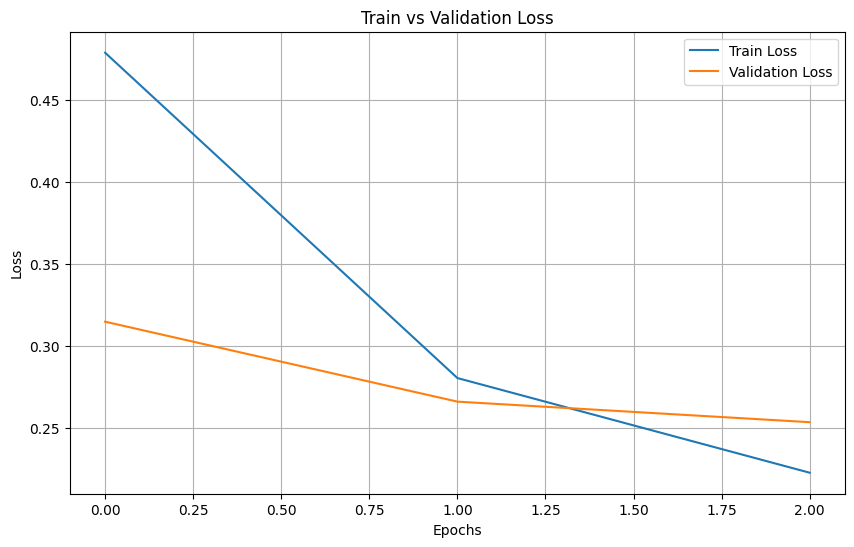

In [43]:
set_seed(42)
model_mlp = MLPClassifier(pretrained=False)
model_mlp.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model_mlp.parameters(), lr=LEARNING_RATE)
print(f"Number of trainable params: {count_trainable_parameters(model_mlp)}")
train_losses = []
val_losses = []
epochs = 3
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_mlp, basic_train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_loss, val_acc, val_f1 = evaluate(model_mlp, basic_val_loader, criterion)
    val_losses.append(val_loss)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")
plot_loss(train_losses, val_losses)

Le nombre d'épochs à choisir est de 3. On a constaté un sur-apprentissage au-delà de cette valeur. Les temps d'entrainement sont plutot courts en comparaison aux modèles qui suivent.

In [65]:
test_loss, test_acc_mlp, test_f1_mlp = evaluate(model_mlp, basic_test_loader, criterion)
print(f"MLP Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_mlp:.4f}, F1 Score: {test_f1_mlp:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

MLP Model - Loss: 0.3291, Accuracy: 0.9000, F1 Score: 0.9022


En ce qui concerne les performances, on constate un très bon score d'*Accuracy* et de *F1*, et ce avec un modèle pourtant simple.

## **CNN 1D**

### Basic

Number of trainable params: 10312141


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/3 | Train Loss: 0.5074 | Train Acc: 0.7399 | Train F1: 0.7424 | Val Loss: 0.3879 | Val Acc: 0.8245 | Val F1: 0.8338 | Time: 65.02s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 2/3 | Train Loss: 0.3175 | Train Acc: 0.8655 | Train F1: 0.8670 | Val Loss: 0.3087 | Val Acc: 0.8657 | Val F1: 0.8645 | Time: 75.28s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 3/3 | Train Loss: 0.2226 | Train Acc: 0.9127 | Train F1: 0.9133 | Val Loss: 0.2834 | Val Acc: 0.8844 | Val F1: 0.8825 | Time: 67.57s


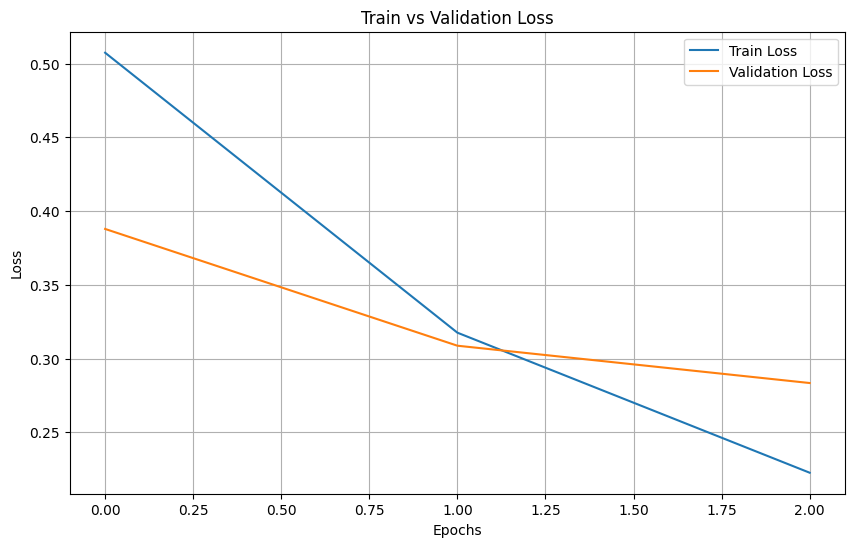

In [51]:
set_seed(42)
model_cnn = CNN1DClassifier(pretrained=False)
model_cnn.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model_cnn.parameters(), lr=LEARNING_RATE)
print(f"Number of trainable params: {count_trainable_parameters(model_cnn)}")
train_losses = []
val_losses = []
epochs = 3
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_cnn, basic_train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_loss, val_acc, val_f1 = evaluate(model_cnn, basic_val_loader, criterion)
    val_losses.append(val_loss)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")
plot_loss(train_losses, val_losses)

In [64]:
test_loss, test_acc_cnn, test_f1_cnn = evaluate(model_cnn, basic_test_loader, criterion)
print(f"CNN 1D Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_cnn:.4f}, F1 Score: {test_f1_cnn:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

CNN 1D Model - Loss: 0.2878, Accuracy: 0.8764, F1 Score: 0.8767


Globalement, les performances de ce modèle sont un peu moins bonnes que le précédent. On converge aussi rapidement mais le temps d'entrainement est plus élevé en comparaison au *MLP*. C'est un point important à considérer.

## **RNN**

### Basic

Number of trainable params: 10130893


  0%|          | 0/4958 [00:00<?, ?it/s]

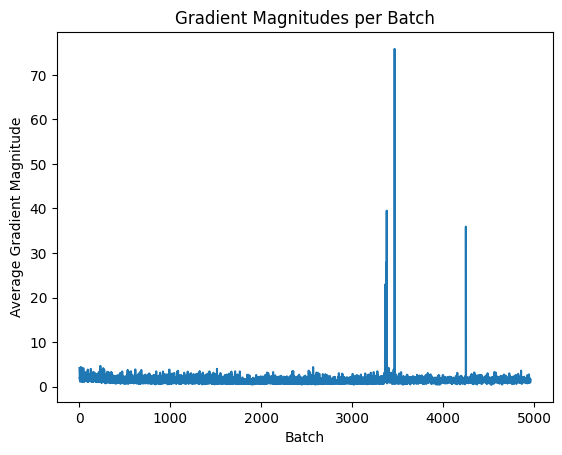

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/1 | Train Loss: 0.6979 | Train Acc: 0.5034 | Train F1: 0.4980 | Val Loss: 0.6987 | Val Acc: 0.4942 | Val F1: 0.4459 | Time: 54.36s


In [54]:
set_seed(42)
model_rnn = RNNClassifier(pretrained=False)
model_rnn.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model_rnn.parameters(), lr=LEARNING_RATE)
print(f"Number of trainable params: {count_trainable_parameters(model_rnn)}")
train_losses = []
val_losses = []
epochs = 1 # On n'affiche donc pas les loss à la fin
plot_grad = True
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_rnn, basic_train_loader, criterion, optimizer, plot_grad=plot_grad)
    plot_grad = False
    train_losses.append(train_loss)
    val_loss, val_acc, val_f1 = evaluate(model_rnn, basic_val_loader, criterion)
    val_losses.append(val_loss)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")

In [63]:
test_loss, test_acc_rnn, test_f1_rnn = evaluate(model_rnn, basic_test_loader, criterion)
print(f"RNN Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_rnn:.4f}, F1 Score: {test_f1_rnn:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

RNN Model - Loss: 0.6967, Accuracy: 0.5025, F1 Score: 0.4689


On observe que les performances du modèle *RNN* sont bien moins bonnes, même en comparaison aux modèles simples comme *MLP*. Pour justifier cette différence on peut s'intéresser aux valeurs des gradients. On constate que ces derniers ont (ici durant la première epoch), des valeurs très **hétérogènes**. Certains ont des valeurs proches de 0 et d'autres de plusieurs centaines. Cela conduit à négliger certaines informations durant la phase de descente de gradient. On peut noter :
$$ \mathcal{L}(x_n, \hat{x_n}) = \mathcal{L}(x_{n-2}, \hat{x}_{n-2}) - s * \nabla_{\theta} \mathcal{L}(x_{n-2}, \hat{x}_{n-2}) - s * \nabla_{\theta} \mathcal{L}(x_{n-1}, \hat{x}_{n-1}) $$ 
Or, si $\nabla_{\theta} \mathcal{L}(x_{n-2}, \hat{x}_{n-2}) << \nabla_{\theta} \mathcal{L}(x_{n-1}, \hat{x}_{n-1})$, alors on risque de perdre l'information contenue dans le gradient de l'instant $n-2$.

### Bert

Number of trainable params: 148097


  0%|          | 0/4958 [00:00<?, ?it/s]

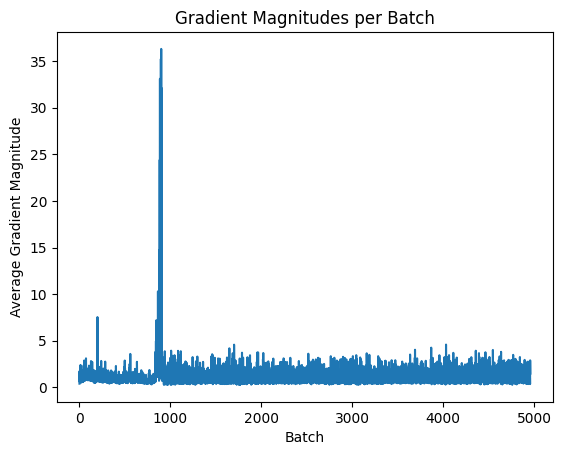

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/2 | Train Loss: 0.6977 | Train Acc: 0.5045 | Train F1: 0.5118 | Val Loss: 0.7113 | Val Acc: 0.5044 | Val F1: 0.2286 | Time: 79.69s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 2/2 | Train Loss: 0.6978 | Train Acc: 0.5019 | Train F1: 0.5183 | Val Loss: 0.6993 | Val Acc: 0.5000 | Val F1: 0.6241 | Time: 69.96s


In [23]:
set_seed(42)
model_rnn_bert = RNNClassifier(pretrained=True, pretrained_embs=BERT_EMBS, embed_size=BERT_EMB_SIZE)
model_rnn_bert.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.AdamW(model_rnn_bert.parameters(), lr=LEARNING_RATE)
print(f"Number of trainable params: {count_trainable_parameters(model_rnn_bert)}")
plot_grad = True
epochs = 2
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_rnn_bert, bert_train_loader, criterion, optimizer, plot_grad=plot_grad)
    plot_grad = False
    val_loss, val_acc, val_f1 = evaluate(model_rnn_bert, bert_val_loader, criterion)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")

In [24]:
test_loss, test_acc_rnn_bert, test_f1_rnn_bert = evaluate(model_rnn_bert, bert_test_loader, criterion)
print(f"RNN with Bert embeddings Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_rnn_bert:.4f}, F1 Score: {test_f1_rnn_bert:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

RNN with Bert embeddings Model - Loss: 0.6988, Accuracy: 0.4938, F1 Score: 0.5241


On remarque le nombre de paramètres à entrainer est bien inférieur comparé au précédent entrainement. Ceci semble logique étant donné que désormais on utilise des *embeddings* pré-entrainés. On constate aussi que les performances sont légèrement meilleures qu'en cherchant à entrainer les couches d'*embeddings*. On peut peut-être expliquer ces différences de performances par les valeurs des gradients. Ceux-ci sont désormais dans une plage de valeurs restreinte (entre 0 et 40). On perd donc moins d'informations.

## **LSTM**

### Basic

Number of trainable params: 10318285


  0%|          | 0/4958 [00:00<?, ?it/s]

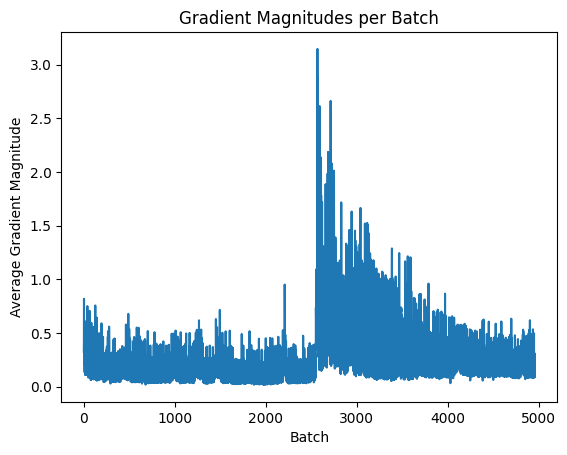

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/4 | Train Loss: 0.6941 | Train Acc: 0.5004 | Train F1: 0.5191 | Val Loss: 0.6921 | Val Acc: 0.5097 | Val F1: 0.1376 | Time: 97.79s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 2/4 | Train Loss: 0.5868 | Train Acc: 0.6487 | Train F1: 0.6442 | Val Loss: 0.3686 | Val Acc: 0.8463 | Val F1: 0.8530 | Time: 92.56s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 3/4 | Train Loss: 0.2736 | Train Acc: 0.8917 | Train F1: 0.8917 | Val Loss: 0.2624 | Val Acc: 0.8949 | Val F1: 0.8975 | Time: 91.54s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 4/4 | Train Loss: 0.1762 | Train Acc: 0.9363 | Train F1: 0.9365 | Val Loss: 0.2470 | Val Acc: 0.9038 | Val F1: 0.9040 | Time: 92.38s


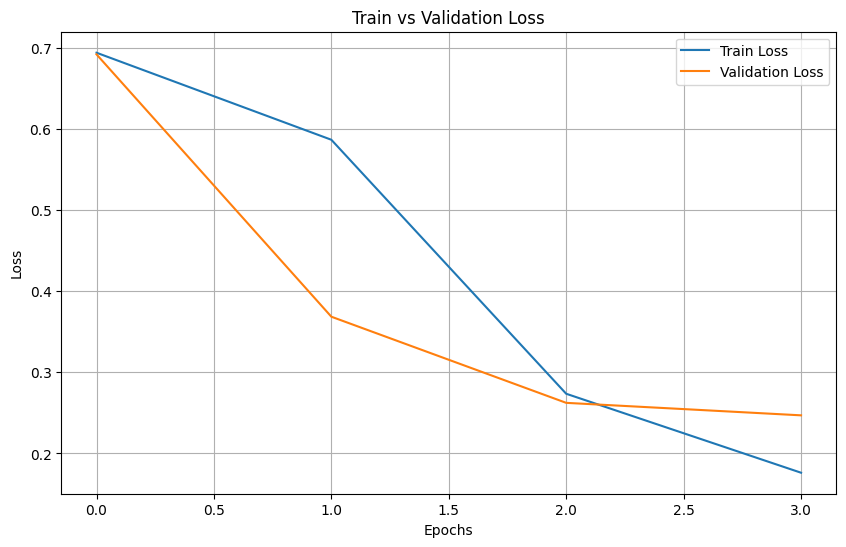

In [56]:
set_seed(42)
model_lstm = LSTMClassifier(pretrained=False)
model_lstm.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)
print(f"Number of trainable params: {count_trainable_parameters(model_lstm)}")
train_losses = []
val_losses = []
epochs = 4
plot_grad = True
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_lstm, basic_train_loader, criterion, optimizer, plot_grad=plot_grad)
    plot_grad = False
    train_losses.append(train_loss)
    val_loss, val_acc, val_f1 = evaluate(model_lstm, basic_val_loader, criterion)
    val_losses.append(val_loss)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")
plot_loss(train_losses, val_losses)

In [62]:
test_loss, test_acc_lstm, test_f1_lstm = evaluate(model_lstm, basic_test_loader, criterion)
print(f"LSTM Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_lstm:.4f}, F1 Score: {test_f1_lstm:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

LSTM Model - Loss: 0.2426, Accuracy: 0.9076, F1 Score: 0.9113


En affichant les valeurs des gradients, on comprend pourquoi les performances du modèle *LSTM* surpassent largement celles du *RNN*. Les gradients sont bien plus **homogènes**. Ceci nous donne une information importante qui est que le caractère sentimental du texte est possiblement contenu en début de phrase. Pour en tirer ce type de conclusion, il suffit de constater la longueur des avis, les valeurs des gradients et enfin les scores obtenus.

### Bert

Number of trainable params: 592001


  0%|          | 0/4958 [00:00<?, ?it/s]

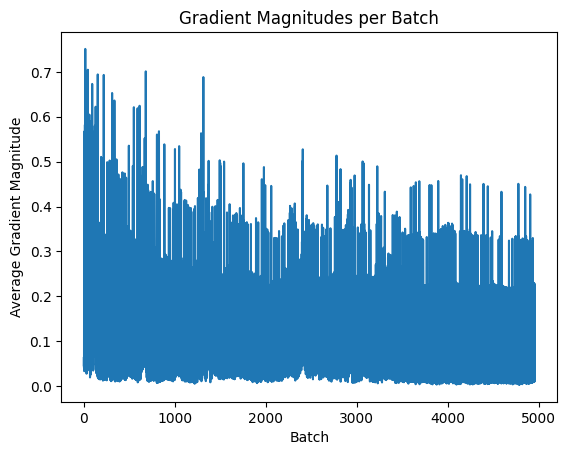

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/1 | Train Loss: 0.6934 | Train Acc: 0.5008 | Train F1: 0.5874 | Val Loss: 0.6933 | Val Acc: 0.4964 | Val F1: 0.6634 | Time: 112.72s


In [27]:
set_seed(42)
model_lstm_bert = LSTMClassifier(pretrained=True, pretrained_embs=BERT_EMBS, embed_size=BERT_EMB_SIZE)
model_lstm_bert.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.AdamW(model_lstm_bert.parameters(), lr=LEARNING_RATE)
print(f"Number of trainable params: {count_trainable_parameters(model_lstm_bert)}")
plot_grad = True
epochs = 1
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_lstm_bert, bert_train_loader, criterion, optimizer, plot_grad=plot_grad)
    plot_grad = False
    val_loss, val_acc, val_f1 = evaluate(model_lstm_bert, bert_val_loader, criterion)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")

In [28]:
test_loss, test_acc_lstm_bert, test_f1_lstm_bert = evaluate(model_lstm_bert, bert_test_loader, criterion)
print(f"LSTM Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_lstm_bert:.4f}, F1 Score: {test_f1_lstm_bert:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

LSTM Model - Loss: 0.6931, Accuracy: 0.5025, F1 Score: 0.6689


Cette fois-ci les scores sont étonamment moins bons. Les gradients bien homogènes mais semblent dégrader les performances. On suppose que les *embeddings* trouvés suite à l'entrainement représentent mieux le caractère sentimental des avis. Cette modèle est à proscrire pour la suite, même si l'entrainement est plus court.

## **GRU**

### Basic

Number of trainable params: 10255821


  0%|          | 0/4958 [00:00<?, ?it/s]

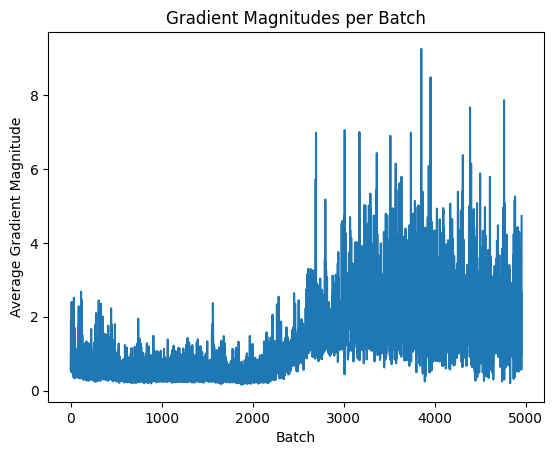

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/2 | Train Loss: 0.5569 | Train Acc: 0.6575 | Train F1: 0.6605 | Val Loss: 0.2857 | Val Acc: 0.8814 | Val F1: 0.8834 | Time: 67.29s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 2/2 | Train Loss: 0.2215 | Train Acc: 0.9104 | Train F1: 0.9108 | Val Loss: 0.2269 | Val Acc: 0.9111 | Val F1: 0.9130 | Time: 137.11s


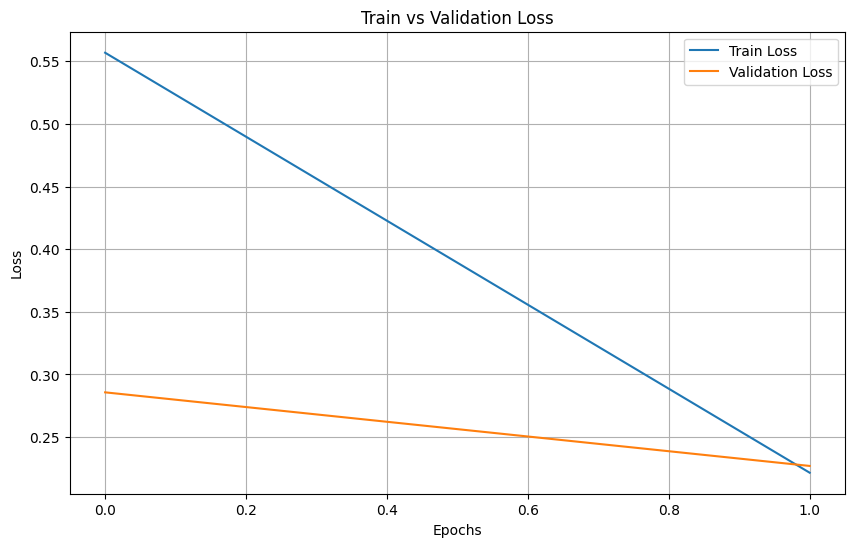

In [59]:
set_seed(42)
model_gru = GRUClassifier(pretrained=False)
model_gru.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model_gru.parameters(), lr=LEARNING_RATE)
print(f"Number of trainable params: {count_trainable_parameters(model_gru)}")
train_losses = []
val_losses = []
epochs = 2
plot_grad = True
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_gru, basic_train_loader, criterion, optimizer, plot_grad=plot_grad)
    plot_grad = False
    train_losses.append(train_loss)
    val_loss, val_acc, val_f1 = evaluate(model_gru, basic_val_loader, criterion)
    val_losses.append(val_loss)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")
plot_loss(train_losses, val_losses)

In [61]:
test_loss, test_acc_gru, test_f1_gru = evaluate(model_gru, basic_test_loader, criterion)
print(f"GRU Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_gru:.4f}, F1 Score: {test_f1_gru:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

GRU Model - Loss: 0.2181, Accuracy: 0.9125, F1 Score: 0.9162


Une fois encore, les gradients ont des valeurs plus **homogènes**. Cela permet d'expliquer les différences de performances par rapport au *RNN*.

### Bert

Number of trainable params: 444033


  0%|          | 0/4958 [00:00<?, ?it/s]

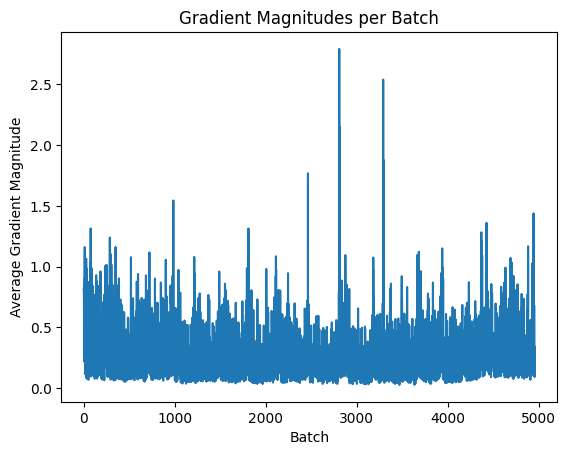

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/7 | Train Loss: 0.6941 | Train Acc: 0.5035 | Train F1: 0.4539 | Val Loss: 0.6933 | Val Acc: 0.4994 | Val F1: 0.6661 | Time: 86.19s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 2/7 | Train Loss: 0.5564 | Train Acc: 0.6493 | Train F1: 0.6492 | Val Loss: 0.2816 | Val Acc: 0.8824 | Val F1: 0.8807 | Time: 78.89s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 3/7 | Train Loss: 0.2617 | Train Acc: 0.8923 | Train F1: 0.8928 | Val Loss: 0.2890 | Val Acc: 0.8802 | Val F1: 0.8689 | Time: 80.89s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 4/7 | Train Loss: 0.2176 | Train Acc: 0.9126 | Train F1: 0.9129 | Val Loss: 0.2419 | Val Acc: 0.9012 | Val F1: 0.8983 | Time: 80.40s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 5/7 | Train Loss: 0.1858 | Train Acc: 0.9267 | Train F1: 0.9269 | Val Loss: 0.2456 | Val Acc: 0.9050 | Val F1: 0.9036 | Time: 78.55s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 6/7 | Train Loss: 0.1619 | Train Acc: 0.9383 | Train F1: 0.9385 | Val Loss: 0.2415 | Val Acc: 0.9068 | Val F1: 0.9077 | Time: 79.07s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 7/7 | Train Loss: 0.1357 | Train Acc: 0.9507 | Train F1: 0.9509 | Val Loss: 0.2440 | Val Acc: 0.9100 | Val F1: 0.9086 | Time: 78.91s


In [24]:
set_seed(42)
model_gru_bert = GRUClassifier(pretrained=True, pretrained_embs=BERT_EMBS, embed_size=BERT_EMB_SIZE)
model_gru_bert.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.AdamW(model_gru_bert.parameters(), lr=LEARNING_RATE)
print(f"Number of trainable params: {count_trainable_parameters(model_gru_bert)}")
epochs = 7
plot_grad = True
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_gru_bert, bert_train_loader, criterion, optimizer, plot_grad=plot_grad)
    plot_grad = False
    val_loss, val_acc, val_f1 = evaluate(model_gru_bert, bert_val_loader, criterion)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")

In [25]:
test_loss, test_acc_gru_bert, test_f1_gru_bert = evaluate(model_gru_bert, bert_test_loader, criterion)
print(f"GRU Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_gru_bert:.4f}, F1 Score: {test_f1_gru_bert:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

GRU Model - Loss: 0.2451, Accuracy: 0.8994, F1 Score: 0.8995


Sur ce dernier modèle, toujours avec des *embeddings Bert*, on atteint des performances équivalentes. Cette fois-ci ce modèle est à considérer. L'entrainement prend par contre plus de temps.

Finalement, les différents tests réalisés avec les *embeddings Bert* ne sont pas suffisamment concluants pour les conserver dans le modèle *global* qui suit. On a décidé d'utiliser tous les modèles dont les *embeddings* ont été entrainés.

*Note : Pour des raisons de redondance et de lisibilité, on a simplement laissé les tests faits avec *Bert* car ceux avec *Glove* étaient d'autant plus mauvais.*

## **Modèle Global**

Finalement, on définit un modèle *global* pour classifier nos textes. Concrétement, on observe la décision de nos précédents modèles entrainés et on conclut par vote majoritaire. Si plus de la moitié des modèles classifient l'avis comme positif, alors on le considère positif, et inversement.

In [66]:
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        predictions = []
        for model in self.models:
            model.eval()
            with torch.no_grad():
                outputs = model(x)
                predictions.append((outputs >= THRESHOLD).float())

        predictions = torch.stack(predictions, dim=0)  # Shape: (num_models, batch_size)
        majority_vote = predictions.sum(dim=0) >= (len(self.models) / 2)
        return majority_vote.float()

In [67]:
models = [model_mlp, model_cnn, model_rnn, model_lstm, model_gru]
ensemble_model = EnsembleModel(models)

# Évaluez le modèle ensemble
test_loss, test_acc_ensemble, test_f1_ensemble = evaluate(ensemble_model, basic_test_loader, criterion)
print(f"Ensemble Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_ensemble:.4f}, F1 Score: {test_f1_ensemble:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

Ensemble Model - Loss: 8.1065, Accuracy: 0.9189, F1 Score: 0.9214


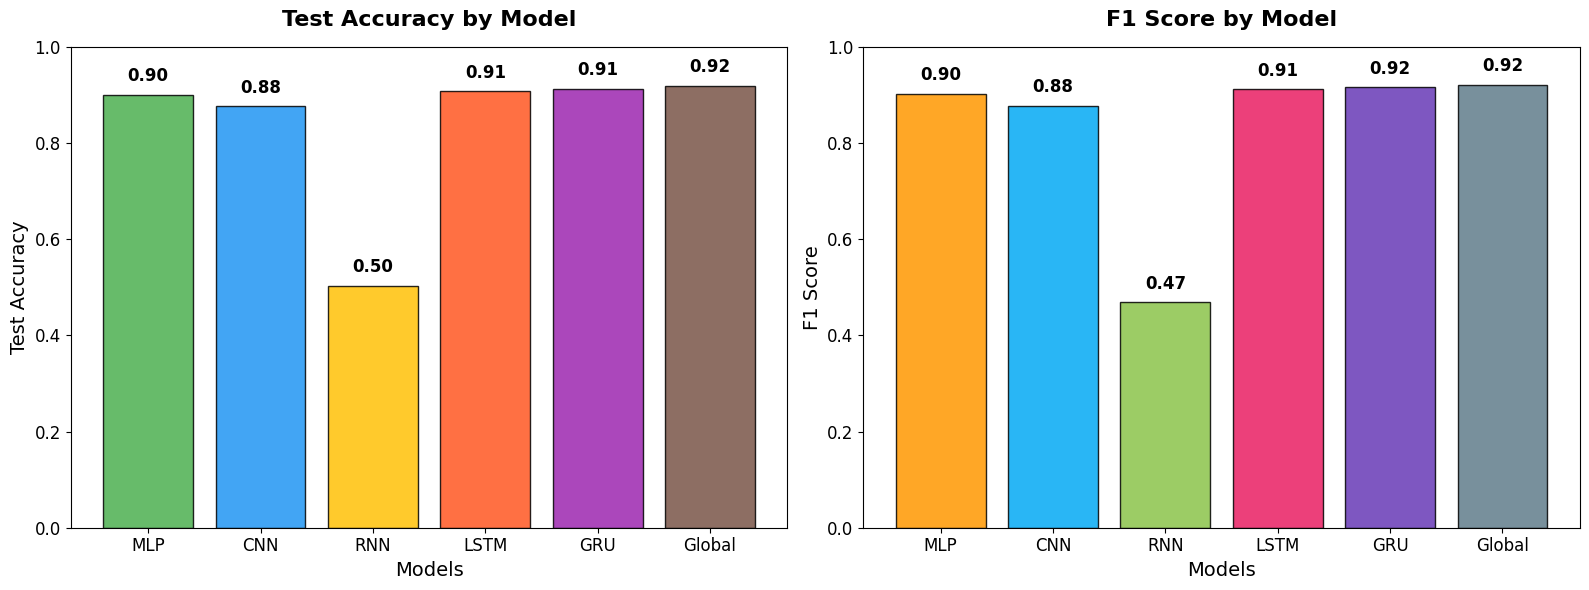

In [68]:
model_list = ['MLP', 'CNN', 'RNN', 'LSTM', 'GRU','Global']
test_scores = [test_acc_mlp.cpu().item() if hasattr(test_acc_mlp, "cpu") else test_acc_mlp,
               test_acc_cnn.cpu().item() if hasattr(test_acc_cnn, "cpu") else test_acc_cnn,
               test_acc_rnn.cpu().item() if hasattr(test_acc_rnn, "cpu") else test_acc_rnn,
               test_acc_lstm.cpu().item() if hasattr(test_acc_lstm, "cpu") else test_acc_lstm,
               test_acc_gru.cpu().item() if hasattr(test_acc_gru, "cpu") else test_acc_gru,
               test_acc_ensemble.cpu().item() if hasattr(test_acc_ensemble, "cpu") else test_acc_ensemble]

f1_scores = [test_f1_mlp.cpu().item() if hasattr(test_f1_mlp, "cpu") else test_f1_mlp,
             test_f1_cnn.cpu().item() if hasattr(test_f1_cnn, "cpu") else test_f1_cnn,
             test_f1_rnn.cpu().item() if hasattr(test_f1_rnn, "cpu") else test_f1_rnn,
             test_f1_lstm.cpu().item() if hasattr(test_f1_lstm, "cpu") else test_f1_lstm,
             test_f1_gru.cpu().item() if hasattr(test_f1_gru, "cpu") else test_f1_gru,
             test_f1_ensemble.cpu().item() if hasattr(test_f1_ensemble, "cpu") else test_f1_ensemble]

# Création des plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Couleurs pour les barres
colors_test_scores = ['#4CAF50', '#2196F3', '#FFC107', '#FF5722', '#9C27B0', '#795548']
colors_f1_scores = ['#FF9800', '#03A9F4', '#8BC34A', '#E91E63', '#673AB7', '#607D8B']

# Premier plot : Test Accuracy
bars1 = axes[0].bar(model_list, test_scores, color=colors_test_scores, edgecolor='black', alpha=0.85)
axes[0].set_title('Test Accuracy by Model', fontsize=16, fontweight='bold', pad=15)
axes[0].set_xlabel('Models', fontsize=14)
axes[0].set_ylabel('Test Accuracy', fontsize=14)
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='both', which='major', labelsize=12)
for bar, acc in zip(bars1, test_scores):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{acc:.2f}', 
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

# Deuxième plot : F1 Score
bars2 = axes[1].bar(model_list, f1_scores, color=colors_f1_scores, edgecolor='black', alpha=0.85)
axes[1].set_title('F1 Score by Model', fontsize=16, fontweight='bold', pad=15)
axes[1].set_xlabel('Models', fontsize=14)
axes[1].set_ylabel('F1 Score', fontsize=14)
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='both', which='major', labelsize=12)
for bar, f1 in zip(bars2, f1_scores):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{f1:.2f}', 
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

# Ajustement du layout
plt.tight_layout()
plt.show()

En affichant tous les scores, on remarque alors ce qui a été dit plus haut. Le modèle *RNN* est le moins performant, certainement en raison de la plage de valeurs que prennent les gradients. Les autres modèles sont relativement proches. Dans ce genre de situation, pour trancher, on peut par exemple se réferrer au temps d'entrainement. Ce serait alors le *MLP* qui serait conservé, avec environ 40 secondes par épochs. Quant au modèle *global*, étant construit sur des modèles pré-entrainés, il présente de bonnes performances, que ce soit pour l*Accuracy* ou bien le *F1-Score*.

## **Pistes d'amélioration**

Dans cette ultime section on va proposer quelques pistes d'amélioration si nous devions poursuivre le projet :
*   Optimiser les hyper-paramètres avec *Optuna*. Les valeurs des hyper-paramètres ont été choisies manuellement, suite à une série de tests. On pourrait employer *Optuna* pour chercher à mieux les optimiser. On choisirait alors un *Sampler* et entrainerait nos modèles pour un panel de valeurs. Plus d'informations ici : https://optuna.org/
*   Employer des *embeddings* différents
*   Travailler avec des modèles *Bert* autres et pré-entrainés. En effet, il existe une panoplie de modèles *Bert*, plus ou moins légers, récents et qui possèdent une partie *Classifier* ou non.
*   Tester des seuils de décision différents. Par défaut, et comme les classes sont équilibrées on est partis sur 0.5. On pourrait essayer d'autres valeurs.